NAME: __TODO: Naveen Jajapur

# Machine Learning Practice - Asynchronous
## Homework D: Classifiers and Cross-Validation

### Objectives
* Implement a classifier that predicts robot motion from infant movements
* Evaluate the classifier by:
  + Using built-in cross-validation tools
  + Computing TPR/FPRs, and displaying ROC curves
* Using hyperparameters to tune a model

## Instructions
* All Homework must be individual work.  Do not look at or copy solutions of other students or that are available on the Internet or via LLMs
* Only work in a copy of the file that is from your ~/homework_in/ directory
   + __If you do not use your own copy of this file, then it is an automatic zero on the assignment__
* Read the code below 
* For any cell that is flagged as *TODO*, complete the code according to the specifications
* Execute each cell and verify that it is showing correct results
* Hand-In Procedure
  + Make sure that your notebook has been saved.  You are responsible for ensuring that the copy that you submit is current and complete
  + The name of the file should be the same as what we gave you
  + Download this file to your local machine (extension: .ipynb)
  + Submit to the Gradescope Notebook HWD dropbox

## General References
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/api/sklearn.linear_model.html)
  + [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/api/sklearn.ensemble.html)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/api/sklearn.model_selection.html)


In [60]:
import pandas as pd
import numpy as np
import os, re, fnmatch
import matplotlib.pyplot as plt
import matplotlib.patheffects as peffects

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
import scipy.stats as stats

# Default figure parameters
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

%matplotlib inline

# LOAD DATA

In [61]:
""" PROVIDED
Load data from subject k3 for week 15
Display info() for the data

These are data obtained from a baby on the SIPPC. 3D Position (i.e. kinematic)
data are collected at 50 Hz, for the x, y, and z positions in meters, for 
various joints such as the wrists, elbows, shoulders, etc.
"""
# File name
#  UPDATE
fname = '/mlp/datasets/baby1/subject_k3_w15.csv'


baby_data_raw = pd.read_csv(fname) 

# Data Selection

In [62]:
""" PROVIDED
"""
## Support for identifying kinematic variable columns
def get_kinematic_properties(data):
    '''
    Given a DataFrame, identify the columns that contain kinematic data

    :param data: A DataFrame
    :return: List of column names that end in _x, _y, or _z
    '''
    # Regular expression for finding kinematic fields
    regx = re.compile("_[xyz]$")

    # Find the list of kinematic fields
    fields = list(data)
    fieldsKin = [x for x in fields if regx.search(x)]
    return fieldsKin

def position_fields_to_velocity_fields(fields, prefix='d_'):
    '''
    Given a list of position columns, produce a new list
    of columns that include both position and velocity

    :param fields: List of position column names
    :return: List of position and velocity column names
    '''
    fields_new = [prefix + x for x in fields]
    return fields + fields_new


In [63]:
""" PROVIDED
Get the names of the sets of fields for the kinematic features and the 
velocities
"""
fieldsKin = get_kinematic_properties(baby_data_raw)
fieldsKinVel = position_fields_to_velocity_fields(fieldsKin)
print(fieldsKinVel)

"""
Fields that describe the linear and rotational velocities of the robot
"""
fieldsRobot = ['robot_vel_l', 'robot_vel_r']


['left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'left_foot_x', 'left_foot_y', 'left_foot_z', 'right_foot_x', 'right_foot_y', 'right_foot_z', 'upper_back_x', 'upper_back_y', 'upper_back_z', 'd_left_wrist_x', 'd_left_wrist_y', 'd_left_wrist_z', 'd_right_wrist_x', 'd_right_wrist_y', 'd_right_wrist_z', 'd_left_elbow_x', 'd_left_elbow_y', 'd_left_elbow_z', 'd_right_elbow_x', 'd_right_elbow_y', 'd_right_elbow_z', 'd_left_shoulder_x', 'd_left_shoulder_y', 'd_left_shoulder_z', 'd_right_shoulder_x', 'd_right_shoulder_y', 'd_right_shoulder_z', 

# Construct Pipeline Components

Copy your Pipeline Elements from HWC into the following cells

In [64]:
# DataFrameSelector
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribs = attribs
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        '''
        :param X: a DataFrame
        :return: a DataFrame that contains the selected attributes
        '''
        return X[self.attribs]

In [65]:
# InterpolationImputer
class InterpolationImputer(BaseEstimator, TransformerMixin):
    def __init__(self, method='quadratic'):
        self.method = method
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X): # TODO
        '''
        :param X: is a DataFrame
        :return: DataFrame without NaNs
        '''
        # Interpolate holes within the data (from class)
        Xout = X.interpolate(method=self.method)
        Xout = Xout.fillna(method='ffill') # this would fill NaN from the beginning 
        Xout = Xout.fillna(method='bfill') # this would fill NaN from the end
        
        
        # Return the imputed dataframe
        return Xout
    

In [66]:
# DerivativeComputer
class DerivativeComputer(BaseEstimator, TransformerMixin):
    def __init__(self, attribs=None, prefix='d_', dt=1.0):
        '''
        Constructor
        
        :param attribs: List of DF attributes that we will compute derivatives for
        :param prefix: Prefix for the new derivative attribute names
        :param dt: Duration between samples
        '''
        self.attribs = attribs
        self.prefix = prefix
        self.dt = dt
    
    def fit(self, x, y=None):
        ''' 
        Nothing to fit
        '''
        return self
    
    def transform(self, X):
        '''
        :param X: a DataFrame
        :return: a DataFrame with additional features for the derivatives
        '''
        Xout = X.copy()
        if self.attribs is None:
            # Default is to differentiate all columns
            self.attribs = Xout.columns

        # Iterate over all of the attributes that we need to compute velocity over
        for attrib in self.attribs:
            # Extract the numpy array of data
            vals = Xout[attrib].values
            # Compute the difference between neighboring timeseries elements
            diff = vals[1:] - vals[0:-1]
            # Take into account the amount of time between timeseries samples
            deriv = diff / self.dt
            # Add a zero to the end so the resulting velocity vector is the same
            #   length as the position vector
            deriv = np.append(deriv, 0)
            
            # Add a new derivative attribute to the DataFrame
            attrib_name = self.prefix + attrib
            Xout[attrib_name] = pd.Series(deriv)

        return Xout

In [67]:
"""
Gaussian kernel

"""

def computeweights(length=3, sigma=1):
    '''
    PROVIDED
    
    Computes the weights for a Gaussian filter kernel
    :param length: the number of terms in the filter kernel
    :param sigma: the standard deviation (i.e. the scale) of the Gaussian
    :return: a vector of filter weights for the Gaussian kernel
    '''
    limit = 2.5
    x = np.linspace(-limit, limit, length)
    kernel = stats.norm.pdf(x, scale=sigma)
    
    # Return the normalized kernel so that the sum is 1
    return kernel / kernel.sum()

In [68]:
# GAUSSIAN FILTER

class GaussianFilter(BaseEstimator, TransformerMixin):
    def __init__(self, attribs=None, kernelsize=3, sigma=1):
        '''
        :param attribs: The list of columns in the DF to filter
        :param kernelsize: Integer number of elements in the Gaussian Kernel
        :param sigma: The standard deviation of the Gaussian Kernel
        '''
        self.attribs = attribs
        
        # Number of kernel elements 
        self.kernelsize = kernelsize
        
        # Check that we have an odd kernel size
        if kernelsize % 2 == 0:
            raise Exception("Expecting an odd kernel size")

        # Standard deviation of the Gaussian
        self.sigma = sigma
        
        # Compute the kernel element values
        self.weights = computeweights(length=kernelsize, sigma=sigma)
        
        print("KERNEL WEIGHTS", self.weights)
    
    def fit(self, x, y=None):
        '''
        Nothing to fit
        '''
        return self
    
    def transform(self, X): # TODO
        '''
        :param X: is a DataFrame
        :return:: a DataFrame with the smoothed signals
        '''
        w = self.weights
        ks = self.kernelsize
        # Create a copy of the original DataFrame
        Xout = X.copy()
        
        # Select all attributes if unspecified
        if self.attribs is None:
          self.attribs = Xout.columns
        
        # Iterate over the attributes
        for attrib in self.attribs:
            # Extract the numpy vector
            vals = Xout[attrib].values
            pad_size = ks // 2 # integer division
            
            # Compute the front and back padding vectors
            frontpad = np.full(pad_size, vals[0]) 
            backpad = np.full(pad_size, vals[-1])
            vals = np.concatenate([frontpad, vals, backpad])
            
            ofst = ks - 1 
            
            # Last term
            avg =  w[ofst] * vals[ofst:]#TODO
            # Rest of the terms
            for i in range(ofst): 
                avg +=  w[i] * vals[i:i-ofst]#TODO
            
            # replace noisy signal with filtered signal
            Xout[attrib] =  pd.Series(avg)# TODO
            
        return Xout
    



# Construct Pipelines

Use the same pipelines from HWC, but add a fifth.

In [69]:
# Pipeline creation

""" 
Create FIVE pipelines. 

COPY FROM hwC
The first pipeline is used for the raw dataframe:
1.  Impute values for the kinematic features using linear interpolation
2.  Smooth the kinematic features.  Use a Gaussian kernel of length 15 
    and standard deviation of 2
3.  Compute derivatives of all of the kinematic features.  dt is 0.02 seconds
-> cleaned DataFrame

The second pipeline extracts the kinematic and velocity (derivative)
features from the cleaned dataframe.

The third pipeline extracts the time stamp from the cleaned dataframe.

The fourth pipeline extracts the robot velocity from the cleaned 
dataframe (both the linear and rotational velocity).

CREATE A NEW FIFTH PIPELINE
Input: cleaned kinematic data from pipe_kin_vel
This pipeline will use the StandardScalar to scale each of the kinematic attributes
Output: scaled data
"""
# Sampling rate: number of seconds between each time sample
dt = .02

# TODO: COPY PIPELINES FROM HWC
pipe_preprocessor = Pipeline([
    #('data_frame', DataFrameSelector(fieldsKin + ['time']+ fieldsRobot)),
    ('linear_interpolation',InterpolationImputer(method='linear')),
    ('gaussian_filter',GaussianFilter(attribs=fieldsKin,kernelsize=15,sigma=2)),
    ('compute_derivatives', DerivativeComputer(attribs=fieldsKin, dt=dt))
    
# TODO
])

#Position, velocity selector
pipe_kin_vel = Pipeline([
    #TODO
    ('pos_frame', DataFrameSelector(fieldsKinVel))
])

# Time selector
pipe_time = Pipeline([
    # TODO
    ('data_frame', DataFrameSelector(['time']))
])

# Robot velocity selector
pipe_robot_vel = Pipeline([
    # TODO
    ('robot_frame', DataFrameSelector(fieldsRobot))
])

## TODO: FIFTH PIPELINE
pipe_scale = Pipeline([
    #TODO
    # ('kin_vel_data', pipe_kin_vel),  
    ('scaler', StandardScaler()) 
])

KERNEL WEIGHTS [0.03977055 0.04893031 0.05831036 0.0673077  0.07525496 0.08149985
 0.08549285 0.08686686 0.08549285 0.08149985 0.07525496 0.0673077
 0.05831036 0.04893031 0.03977055]


## Pre-process and extract data

Copy your preprocessing code from HW C


In [70]:
# Process the data

# TODO: COPY PIPELINE PROCESSING FROM HWC
# TODO: use the first pipeline to perform an initial cleaning of the data
baby_data_clean = pipe_preprocessor.fit_transform(baby_data_raw)# TODO
# TODO: Use the result from the first pipeline to extract the kinematic and 
#       velocity features by using the pipe_kin_vel pipeline
data_pos_vel = pipe_kin_vel.fit_transform(baby_data_clean)# TODO

# TODO: Use the result from the first pipeline to extract the time stamps by using
#       the pipe_time pipeline
data_time =  pipe_time.fit_transform(baby_data_clean)# TODO


# TODO: Use the result from the first pipeline to get the robot velocity by using
#       the pipe_robot_vel pipeline
data_robot_vel = pipe_robot_vel.fit_transform(baby_data_clean)#TODO

# PROVIDED: Transform the dataframes as numpy arrays
inputs_pos_vel = data_pos_vel.values
time = data_time.values
robot_vel = data_robot_vel.values

nsamples = inputs_pos_vel.shape[0]


# NEW: PROVIDED
inputs_pos_vel_scaled = pipe_scale.fit_transform(data_pos_vel)

# Visualization Tools
All provided

In [71]:
'''
PROVIDED
'''
def visualize_model_output_timeseries(y, preds, scores, threshold=0, 
                                      offset_pred=-2, offset_scores=-8):
    '''
    Plot timeseries on a single axis:
    1. True class (y)
    2. Predicted class (preds)
    3. Prediction scores (scores)
    
    In addition, draw a horizontal line over the scores that shows the decision 
    threshold (by default the decision threshold is zero)
    
    Don't forget to supply a meaningful legend and to label the horizontal axis
    '''
    
    plt.figure()

    plt.plot(time, y, 'b', label='Target')
    plt.plot(time, preds+offset_pred, 'r', label='Prediction')
    plt.plot(time, scores+offset_scores, 'g', label='Score')
    plt.plot([0, time.max()], [offset_scores+threshold, offset_scores+threshold], 
             'k', label='Threshold')
    plt.xlabel("Time (s)")
    plt.legend()
    
    
'''
PROVIDED

Generate a K-S plot and a ROC plot.

'''
def ks_roc_plot(targets, scores, FIGWIDTH=12, FIGHEIGHT=6, FONTSIZE=16):
    ''' 
    Generate a figure with two subplots:
    1.  TPR and FPR (and their difference) as a function of decision threshold
    2.  ROC Curve 
    
    On both subplots, clearly show the threshold that corresponds to the
    K-S distance using either a line or a point (choose the most appropriate
    one)
    
    :param targets: list of true target labels
    :param scores: list of predicted labels or scores
    :param FIGWIDTH: figure width
    :param FIGHEIGHT: figure height
    :param FONTSIZE: font size for text
        
    :return:
        fpr: false positive rate (vector)
        tpr: true positive rate (vector)
        thresholds: thresholds used for the ROC curve (vector)
        ind: the index in thresholds that corresponds to the K-S distance
        thr: the threshold that corresponds to the K-S distance
        auc: Area under the ROC Curve
        fig, axs: corresponding handles for the figure and axis
        
    '''
    # Compute fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(targets, scores)
    # Compute AUC
    auc_res = auc(fpr, tpr)  

    # Compute the difference between tpr and fpr
    diff = tpr-fpr
    # Compute the index that corresponds to the maximum difference
    ind = np.argmax(diff)  
    # Compute the threshold for the maximum difference
    thr = thresholds[ind] 

    # Generate figure with two axes
    fig, ax = plt.subplots(1, 2, figsize=(FIGWIDTH,FIGHEIGHT))
    axs = ax.ravel()  # Individual axes are now ax[0] and ax[1]
    
    # plot TPR, FPR and difference
    ax[0].plot(thresholds, tpr, color='b')
    ax[0].plot(thresholds, fpr, color='r')
    ax[0].plot(thresholds, tpr - fpr, color='k')
    ax[0].plot([thr, thr], [0, 1], color='m')
    ax[0].invert_xaxis()
    ax[0].set_xlabel('threshold', fontsize=FONTSIZE)
    ax[0].set_ylabel('fraction', fontsize=FONTSIZE)
    ax[0].legend(['TPR', 'FPR', 'Difference', 'K-S Threshold'], fontsize=FONTSIZE)
    
    # Generate ROC Curve plot
    ax[1].plot(fpr, tpr, color='b')
    ax[1].plot([0,1], [0,1], 'r--')
    ax[1].plot(fpr[ind], tpr[ind], 'mo')
    ax[1].set_xlabel('FPR', fontsize=FONTSIZE)
    ax[1].set_ylabel('TPR', fontsize=FONTSIZE)
    ax[1].set_aspect('equal', 'box')
    auc_text = ax[1].text(.05, .95, "AUC = %.4f" % auc_res, 
                          color="k", fontsize=FONTSIZE)
    print("AUC:", auc_res)

    return fpr, tpr, thresholds, ind, thr, auc_res, fig, axs


""" 


Plot histograms of the scores from the model.
"""

def plot_score_histograms(scores, y, thr=None, nbins = 41, 
                          FIGWIDTH=8, FIGHEIGHT=4):
    '''
    Generate two plots (in a single figure):
    1. Histogram of all scores
    2. Two overlapping histograms: one for positive examples 
            and the other for negative examples
    
    :param scores: Model scores for all samples
    :param y: Ground truth labels for all samples
    :param thr: Threshold to indicate on the plot
    :param nbins: Number of bins used for the histograms
    :param FIGWIDTH: Figure width
    :param FIGHIGHT: Figure height
    '''

    # Given all the scores and the true class labels, create
    #  lists of scores for the positive and negative cases, respctively
    scores_pos = [s for (s, l) in zip(scores, y) if l]    
    scores_neg = [s for (s, l) in zip(scores, y) if not l] 

    plt.figure(figsize=(FIGWIDTH, FIGHEIGHT))
    plt.subplot(1,2,1)
   
    n, bins, patches = plt.hist(scores, bins=nbins)  
    if thr is not None:
        plt.plot([thr, thr], [0, np.max(n)*1.05], 'm')
        
    plt.xlabel('score')
    plt.ylabel('count')

    plt.subplot(1,2,2)
    n1, bins1, patches1 = plt.hist(scores_pos, bins=nbins, alpha=0.5, label = "+") 
    n2, bins2, patches2 = plt.hist(scores_neg, bins=nbins, alpha=0.5, label = "-") 
    plt.plot([thr, thr], [0, np.max(np.concatenate([n1,n2]))*1.05], 'm')
    plt.xlabel('score')
    plt.legend(loc='upper right')

In [72]:
""" PROVIDED
"""
# Generate a color map plot for a confusion matrix
def confusion_mtx_colormap(mtx, xnames, ynames, cbarlabel="", FIGWIDTH=5, FIGHEIGHT=5, FONTSIZE=14):
    ''' 
    Generate a figure that plots a colormap of a matrix
    PARAMS:
        mtx: matrix of values
        xnames: list of x tick names
        ynames: list of the y tick names
        cbarlabel: label for the color bar
    RETURNS:
        fig, ax: the corresponding handles for the figure and axis
    '''
    nxvars = mtx.shape[1]
    nyvars = mtx.shape[0]
    
    # create the figure and plot the correlation matrix
    fig, ax = plt.subplots(figsize=(FIGWIDTH, FIGHEIGHT))
    im = ax.imshow(mtx, cmap='summer')
    if not cbarlabel == "":
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    
    # Specify the row and column ticks and labels for the figure
    ax.set_xticks(range(nxvars))
    ax.set_yticks(range(nyvars))
    ax.set_xticklabels(xnames)
    ax.set_yticklabels(ynames)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("Actual Labels")

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, 
             ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    lbl = np.array([['TN', 'FP'], ['FN', 'TP']])
    for i in range(nyvars):
        for j in range(nxvars):
            text = ax.text(j, i, "%s = %.0f" % (lbl[i,j], mtx[i, j]),
                           ha="center", va="center", color="k")
            #text.set_path_effects([peffects.withStroke(linewidth=2, 
            #foreground='w')])

    return fig, ax


def display_confusion_matrix(y, preds, label_names):
    """ 
    Compute the confusion matrix using sklearn's confusion_matrix() function and 
    generate a color map using the provided confusion_mtx_colormap() for the model 
    built using the distance labels.
    
    :params y: Ground truth labels
    :params preds: Crisp predictions made by the model (i.e., after thresholding)
    :return: Number of positive and negative examples (ground truth)
    """
    dist_confusion_mtx = confusion_matrix(y, preds)
    confusion_mtx_colormap(dist_confusion_mtx, label_names, label_names, cbarlabel="") # TODO

    nneg = dist_confusion_mtx[0].sum()
    npos = dist_confusion_mtx[1].sum()
    return npos, nneg, dist_confusion_mtx

# Robot Velocity Labels

In [73]:
""" PROVIDED
Create labels that correspond to "fast forward motion",
"fast left rotational motion", "fast right rotational motion"

"""
# Fast forward motion
labels_linear = robot_vel[:,0] > 0.002

# Leftward turns
labels_rotational_l = (robot_vel[:,1]) > 0.02
# Rightward turns
labels_rotational_r = (robot_vel[:,1]) < -0.02

# Classification Using Cross Validation


In [74]:
""" TODO
LINEAR VELOCITY

Create a SGDClassifier with random_state=1138, max_iter=10000, tol=1e-3, and
that uses the log_loss function.  As with HWC, this model will take as input
the positions and velocities & predict the robot linear velocity labels. 
However, we will use cross_val_predict() to fit N models, and compute 
predictions for each sample and their corresponding scores. Use N=20 cross 
validation splits (i.e. cv=20).

Call cross_val_predict() with two different "methods": 
- decision_function will return the decision function scores for each sample
- predict will return the predicted class for each sample
(sadly, this causes us to fit a model for each rotation twice)

"""
# Model input
X = inputs_pos_vel
# Model output
y = labels_linear

# TODO: Create and fit the classifer
clf3 = SGDClassifier(random_state=1138, max_iter=10000, tol=1e-3, loss='log_loss')# TODO

# TODO: use cross_val_predict() to compute the scores by setting the 'method'
#       parameter equal to 'decision_function'. Please see the reference 
#       links above
scores =  cross_val_predict(clf3, X, y, cv=20, method='decision_function')# TODO

# TODO: use cross_val_predict() to compute the predicted labels by setting 
#       the 'method' parameter equal to 'predict'. Please see the reference 
#       links above
preds = cross_val_predict(clf3, X, y, cv=20, method='predict') # TODO

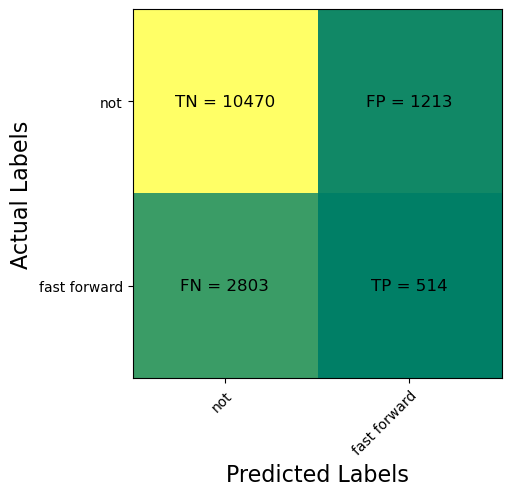

In [75]:
# EXECUTE CELL
npos, nneg, conf = display_confusion_matrix(y, preds, ['not', 'fast forward'])


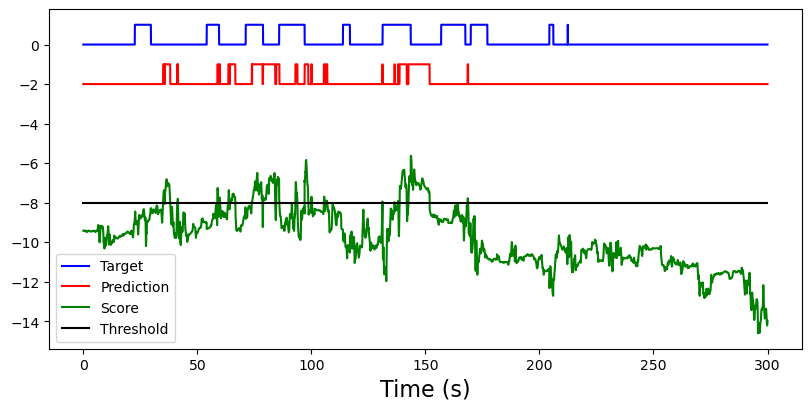

In [76]:
# EXECUTE CELL: Visualize the predictions made by the model in timeseries form
visualize_model_output_timeseries(y, preds, scores)

AUC: 0.7184573665432932
Best: 2539 -1.373665129500849


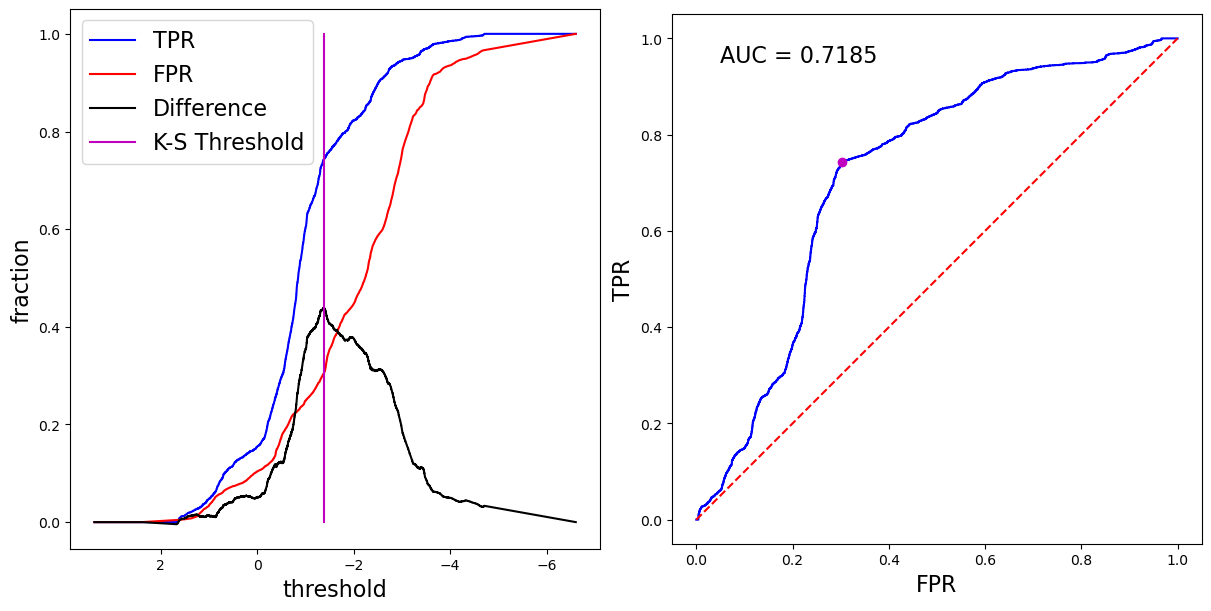

In [77]:
# EXECUTE CELL: Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, index_best, thresh, auc_res, fig, axs = ks_roc_plot(y, scores) 
ind_best = np.argmax(tpr-fpr)
print("Best:", ind_best, thresholds[ind_best])

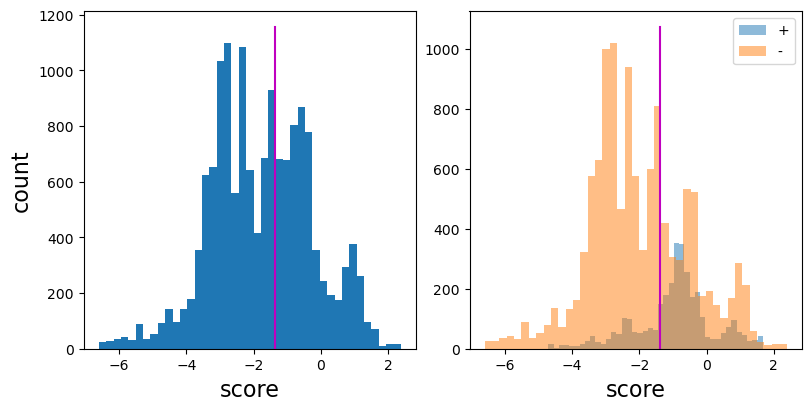

In [78]:
# EXECUTE CELL: Plot score histograms
plot_score_histograms(scores, y, thr=thresh)

## Cross-validation for Rotational Velocity

In [79]:
""" TODO
ROTATIONAL VELOCITY

Create a new SGDClassifier as above.  Train with positions and velocities 
as inputs and predict the leftward rotational velocity class.  
Use cross_val_predict() to fit N models and produce predictions and corresponding
scores for each sample.  Use 20 cross validation splits (i.e. cv=20).

"""
# Model input
X = inputs_pos_vel
# Model output
y = labels_rotational_l

# TODO: Create and fit the classifer
clf4 = SGDClassifier(random_state=1138, max_iter=10000, tol=1e-3, loss='log_loss') # TODO

# TODO: use cross_val_predict() to compute the scores by setting the 'method'
#       parameter equal to 'decision_function'. Please see the reference 
#       links above
scores =  cross_val_predict(clf4, X, y, cv=20, method='decision_function') # TODO
    
# TODO: use cross_val_predict() to compute the predicted labels by setting 
#       the 'method' parameter equal to 'predict'. Please see the reference 
#       links above
preds =  cross_val_predict(clf4, X, y, cv=20, method='predict')# TODO

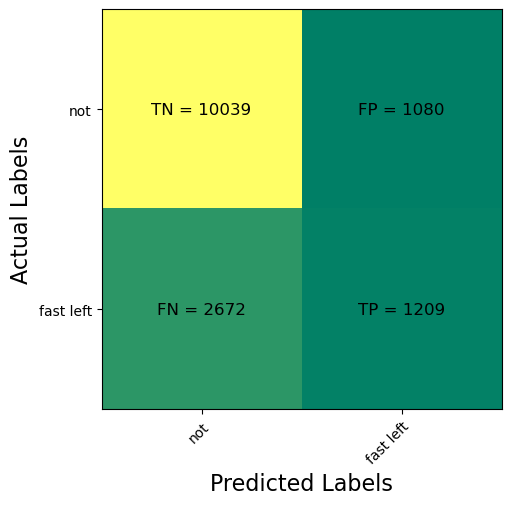

In [80]:
# EXECUTE CELL
npos, nneg, conf=display_confusion_matrix(y, preds, ['not', 'fast left'])


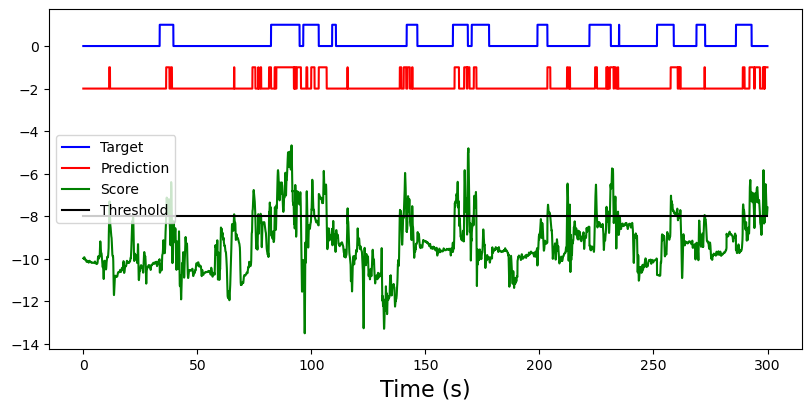

In [81]:
# EXECUTE CELL: Visualize the predictions made by the model in timeseries form
visualize_model_output_timeseries(y, preds, scores)

AUC: 0.7464190478869768
Best: 3166 -1.3926241816892815


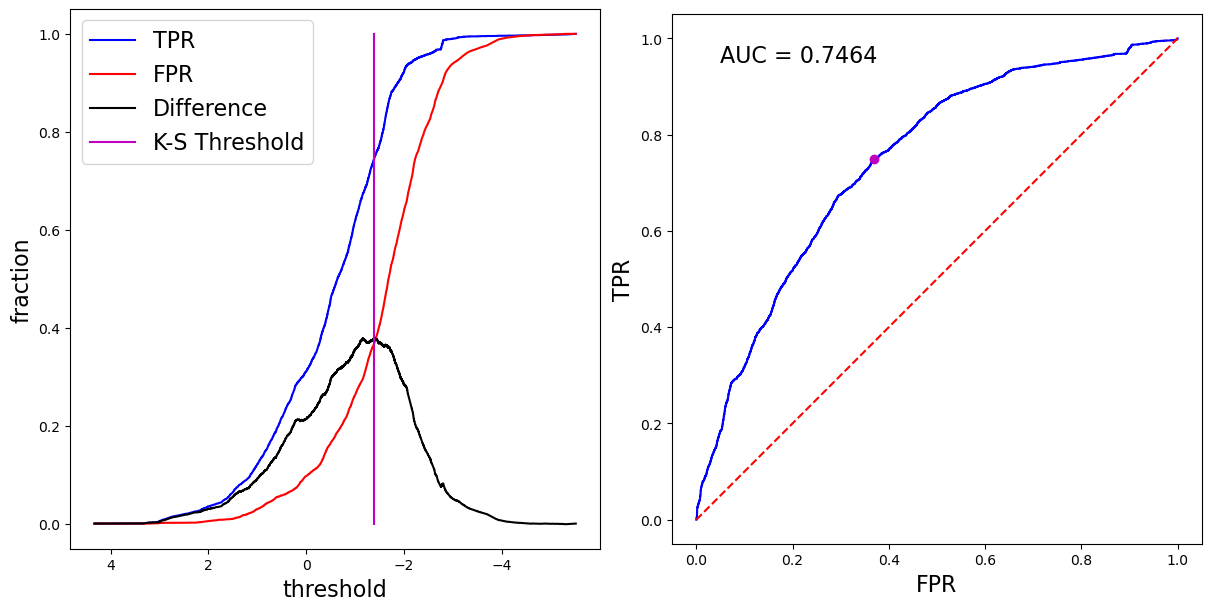

In [82]:
# EXECUTE CELL: Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, index_best, thresh, auc_res, fig, axs = ks_roc_plot(y, scores) 
ind_best = np.argmax(tpr-fpr)
print("Best:", ind_best, thresholds[ind_best])

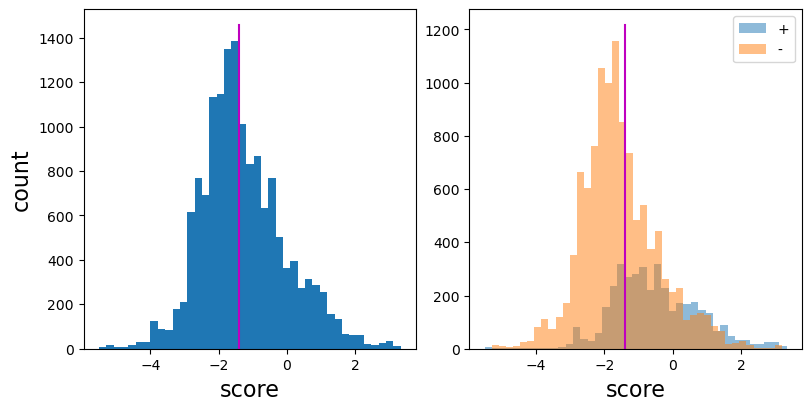

In [83]:
# EXECUTE CELL: Plot score histograms
plot_score_histograms(scores, y, thresh)

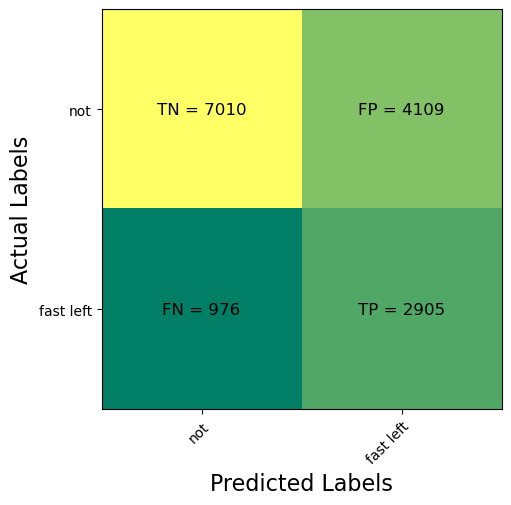

In [84]:
# TODO: compute and display the confusion matrix for the ideal threshold
preds_ideal = (scores >= thresh).astype(int)#TODO

# PROVIDED
npos, nneg, conf=display_confusion_matrix(y, preds_ideal, ['not', 'fast left'])

## Using Scaled Inputs

To this point, we have used unscaled inputs to our model.  Here, we will use the scaled inputs that we have already prepared.  


In [85]:
""" TODO
ROTATIONAL_VELOCITY_L

Create a new SGDClassifier as above.  Train with SCALED positions and velocities 
as inputs and predict the leftward rotational velocity class.  
Use cross_val_predict() to fit N models and produce predictions and corresponding
scores for each sample.  Use 20 cross validation splits (i.e. cv=20).

NOTE: this is the same implementation as the previous model, but with scaled inputs
"""
# Model input
X = inputs_pos_vel_scaled
# Model output
y = labels_rotational_l

# TODO: Create and fit the classifer
clf5 = SGDClassifier(random_state=1138, max_iter=10000, tol=1e-3, loss='log_loss') # TODO

# TODO: use cross_val_predict() to compute the scores by setting the 'method'
#       parameter equal to 'decision_function'. Please see the reference 
#       links above
scores = cross_val_predict(clf5, X, y, cv=20, method='decision_function') # TODO
    
# TODO: use cross_val_predict() to compute the predicted labels by setting 
#       the 'method' parameter equal to 'predict'. Please see the reference 
#       links above
preds = cross_val_predict(clf5, X, y, cv=20, method='predict') # TODO

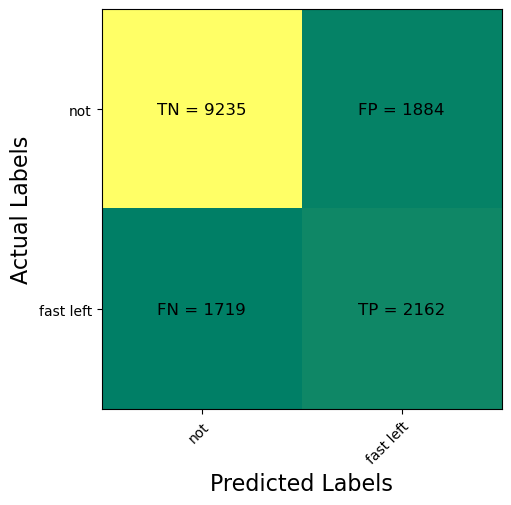

In [86]:
# EXECUTE CELL
npos, nneg, conf = display_confusion_matrix(y, preds, ['not', 'fast left'])


AUC: 0.773272646094038
Best: 1946 -0.3665153028878865


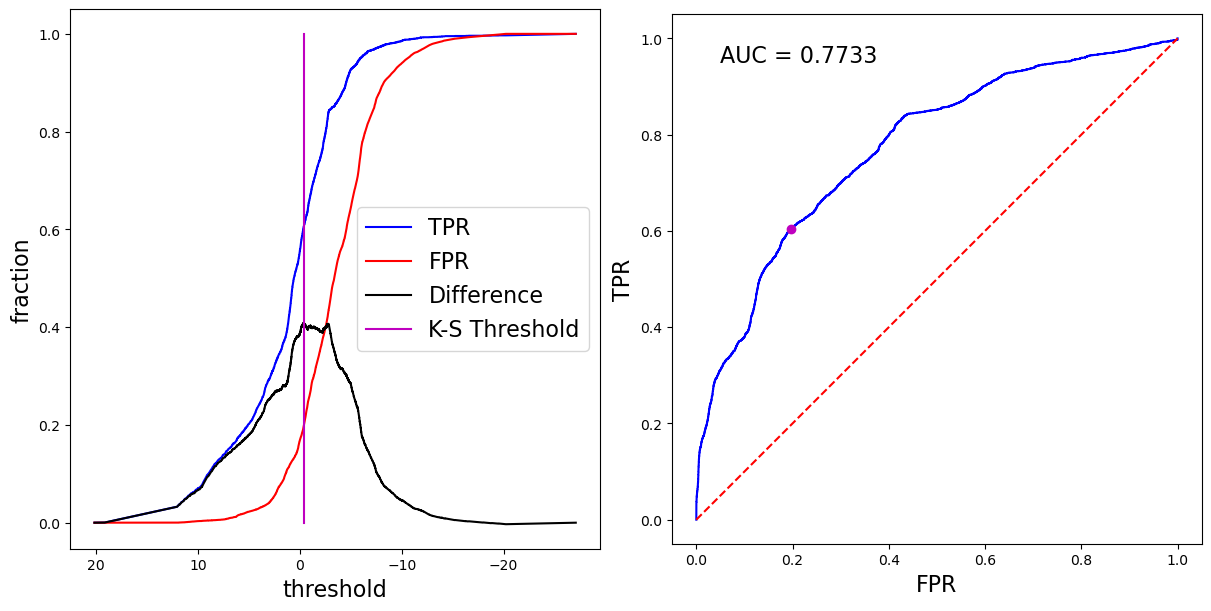

In [87]:
# EXECUTE CELL: Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, index_best, thresh, auc_res, fig, axs = ks_roc_plot(y, scores) 
ind_best = np.argmax(tpr-fpr)
print("Best:", ind_best, thresholds[ind_best])

## Changing Hyper-Parameters

In [88]:
""" TODO
LINEAR_VELOCITY

Following what we have done with the above LINEAR velocity model above, create a new
SGDClassifier with the same parameters with one exception: set the alpha parameter to
0.001.  This "L2" regularization hyper-parameter controls the complexity of the model 
that is learned; the default value is 0.0001, so by increasing the value of this 
hyperparameter, we are allowing less complex models.  We will talk more in class about 
hyperparameters and regularization in the coming weeks! [NOTE: in class, I said that 
alpha was the learning rate parameter;  learning rate is the 'learning_rate' argument]

Use the UNSCALED pos_vel inputs
"""
# Model input
X = inputs_pos_vel
# Model output
y = labels_linear



# TODO: Create and fit the classifer
clf6 = SGDClassifier(random_state=1138, max_iter=10000, tol=1e-3, loss='log_loss', alpha=0.001) # TODO

# TODO: use cross_val_predict() to compute the scores by setting the 'method'
#       parameter equal to 'decision_function'. Please see the reference 
#       links above
scores = cross_val_predict(clf6, X, y, cv=20, method='decision_function')# TODO

# TODO: use cross_val_predict() to compute the predicted labels by setting 
#       the 'method' parameter equal to 'predict'. Please see the reference 
#       links above
preds =  cross_val_predict(clf6, X, y, cv=20, method='predict')# TODO

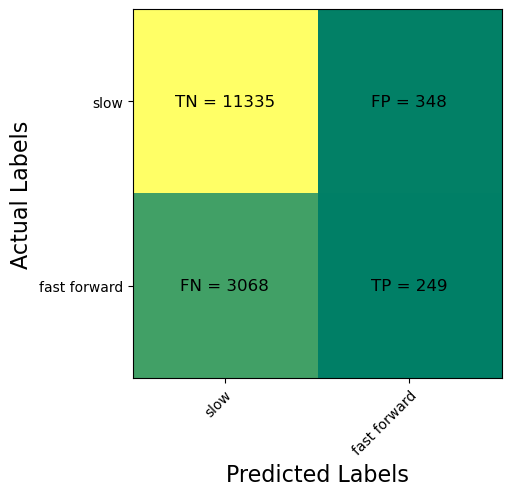

In [89]:
# EXECUTE CELL
npos, nneg, conf = display_confusion_matrix(y, preds, ['slow', 'fast forward'])

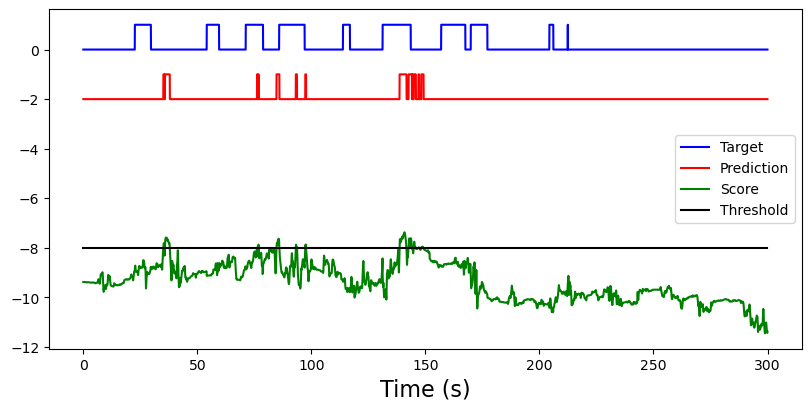

In [90]:
# EXECUTE CELL: Visualize the predictions made by the model in timeseries form
visualize_model_output_timeseries(y, preds, scores)

AUC: 0.7544155009723111
Best: 2678 -1.1514129861095532


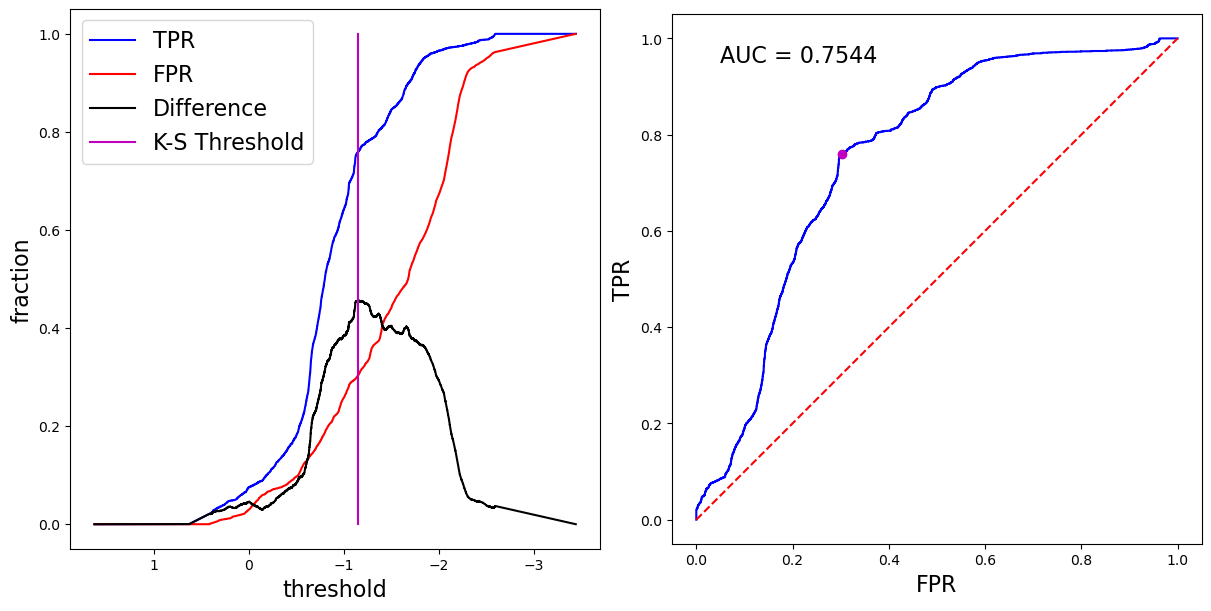

In [91]:
# EXECUTE CELL: Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, index_best, thresh, auc_res, fig, axs = ks_roc_plot(y, scores) 
ind_best = np.argmax(tpr-fpr)
print("Best:", ind_best, thresholds[ind_best])

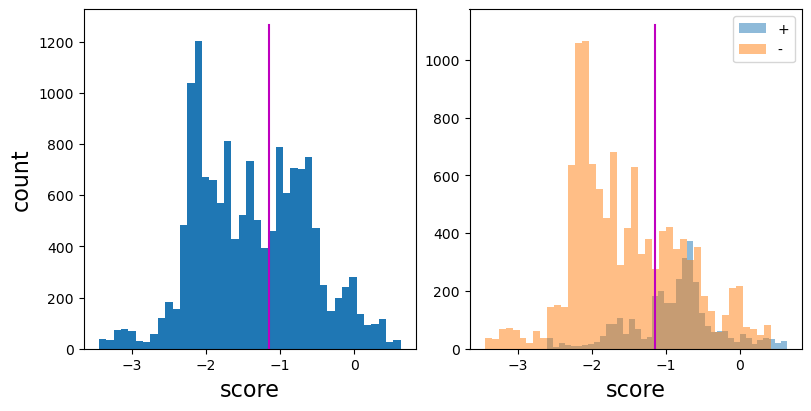

In [92]:
# EXECUTE CELL: Plot score histograms
plot_score_histograms(scores, y, thresh)

# Reflection

Provide short answers to each of the following questions.

_Q1. Compare the performance of the linear velocity model from HWC (the "first classifier") to the performance of the first model in *this* assignment (also linear velocity).  Explain the difference_

**ANS** The first classifier (HWC) usees the same dataset, which increases the risk of overfitting and can result in an inflated accuracy. In contrast, the second classifier(this assignment) applies cross-validation with 20 splits, training on various subsets and evaluating on unseen data, which leads to more reliable and generalizable performance. The main difference is that the HWC model risks overfitting by being trained and tested on the same data, while the cross-validated model in this assignment provides more generalizable and realistic performance by testing on unseen data.

_Q2. For the left rotation model in this assignment, you produced two confusion matrices.  What changes between these two matrices and why?_

**ANS** The second confusion matrix applies an optimized threshold, resulting in a higher number of true positives but also slightly more false positives. On the other hand, the first confusion matrix reflects the model's regular predictions, showing fewer false positives but missing more "fast left" cases, leading to an increase in false negatives.


_Q3. How does using scaled inputs change model performance?_

**ANS** Using scaled inputs, the model reduces the likelihood of false positives and false negatives, achieving more consistent predictions and better accuracy, which in turn increases true positives and enhances the model's overall performance.

_Q4. How does altering the L2 regularization hyper-parameter affect model performance?_

**ANS** The model becomes simpler when the L2 regularization value (alpha) is raised to 0.001, which lowers the likelihood of overfitting and helps the model focus on important features. This, however, may also lead the model to miss more subtle information, which could reduce accuracy when identifying intricate patterns, like slight variations in linear velocity. It stricks a balance between accuracy and simplicity.

_Q5.  For the TPR curves: explain why they monotonically increase as the threshold sweeps from a high value to a low value._

**ANS** The TPR curve increases as the threshold gets lower from a higher value because the model starts classifying more cases as positive, including more true positives. As the threshold decreases, even borderline cases are marked positive, which raises the TPR until almost all true positives are captured.
